# 0. Imports

In [99]:
from dotenv import load_dotenv
import os
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from fractions import Fraction
from math import floor, gcd, log, ceil
import numpy as np
import datetime


# 1. Configurações Iniciais

## 1.1. Carrega variáveis de ambiente

In [100]:
load_dotenv()
API_KEY = os.getenv('IBM_QUANTUM_API_KEY')
INSTANCE_CRN = os.getenv('IBM_QUANTUM_INSTANCE_CRN')

## 1.2. Configura conta da IBM Cloud com instância especificada

In [101]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=API_KEY,
    instance=INSTANCE_CRN, 
    overwrite=True,
    set_as_default=True
)

# 2. Códigos

## 2.1. Roda medição de um qubit aplicado a uma porta Hadamard

In [102]:
# 1. Inicializar serviço (assume que você já autenticou com save_account)
service = QiskitRuntimeService()

# 2. Selecionar o backend real menos ocupado
backend = service.least_busy(operational=True, simulator=False)

# 3. Criar circuito simples (e medir)
qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()

# 4. Transpilar para o backend
qc_isa = transpile(qc, backend=backend)

# 5. Criar Sampler informando o backend — usando o modo moderno:
sampler = Sampler(mode=backend)

# 6. Enviar o job (como lista de circuitos)
job = sampler.run([qc_isa], shots=1024)
job_id = job.job_id()
# print("Job ID:", job_id)
print("Status:", job.status())

Status: QUEUED


Status: DONE
Counts: {'0': 507, '1': 517}


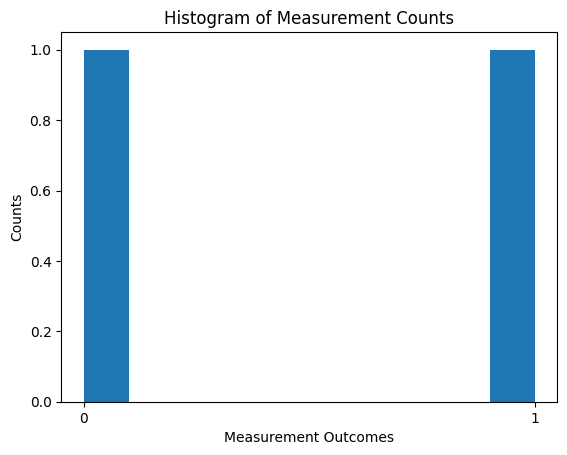

In [104]:
job = service.job(job_id)
print("Status:", job.status())

if job.status() == "DONE":
    # 7. Capturar o resultado
    result = job.result()
    counts = result[0].data.meas.get_counts()

    # 8. Visualizar resultados
    print("Counts:", counts)
    plt.hist(counts)
    plt.title("Histogram of Measurement Counts")
    plt.xlabel("Measurement Outcomes")
    plt.ylabel("Counts")

    plt.show()

else:
    print("Job not completed")

## 2.2. Descobrindo número de qubits do backend utilizado

In [105]:
backends = service.backends(simulator=False, operational=True)
for backend in backends:
    print(f"Backend: {backend.name},\tQubits: {backend.num_qubits},\tOperational: {backend.status().operational}")


Backend: ibm_torino,	Qubits: 133,	Operational: True
Backend: ibm_brisbane,	Qubits: 127,	Operational: True


## 2.3. Criando código do algoritmo de Shor

### 2.3.1. Frações Contínuas

In [106]:
def continued_fraction(x, max_denominator):
    """Aproxima x como uma fração com denominador ≤ max_denominator"""
    frac = Fraction(x).limit_denominator(max_denominator)
    return frac.numerator, frac.denominator


### 2.3.2. Porta de operação modular

In [108]:
def c_mod_mult_gate(b, N):
  """
  Retorna a versão controlada da porta modular que implementa |x⟩ → |b·x mod N⟩
  controlada por 1 qubit.

  Parâmetros:
  - b: inteiro multiplicador (coprimo de N)
  - N: inteiro módulo

  Retorna:
  - Uma UnitaryGate controlada (1 qubit de controle)
  """
  if gcd(b, N) > 1:
      raise ValueError(f"Erro: gcd({b}, {N}) > 1 — b e N devem ser coprimos.")

  n = floor(log(N - 1, 2)) + 1  # Número de qubits necessários para representar N
  U = np.zeros((2**n, 2**n))

  for x in range(N):
      U[b * x % N][x] = 1
  for x in range(N, 2**n):
      U[x][x] = 1  # Mapeia fora do domínio válido para identidade

  base_gate = UnitaryGate(U, label=f"{b}×mod{N}")
  controlled_gate = base_gate.control()  # Cria a versão com 1 qubit de controle

  return controlled_gate

### 2.3.3. Define circuito de *Order Finding*

In [109]:
def order_finding_circuit(N, a, m=None, view_circuit=False):
    if m is None:
      m = ceil(2 * log(N, 2)) + 1  # Número de qubits de controle
    n = floor(log(N - 1, 2)) + 1  # Número de qubits de dados (registrador modular)

    # Registradores
    q_control = QuantumRegister(m, 'ctrl')
    q_data = QuantumRegister(n, 'data')
    c_out = ClassicalRegister(m, 'c')
    qc = QuantumCircuit(q_control, q_data, c_out)

    # Estado inicial |1⟩ no registrador de dados
    qc.x(q_data[0])

    # Hadamard em todos os qubits de controle
    for i in range(m):
        qc.h(q_control[i])

    # Aplicar operações controladas: a^(2^i) mod N
    for i in range(m):
        exponent = 2 ** i
        mod_gate = c_mod_mult_gate(pow(a, exponent, N), N)
        qc.append(mod_gate, [q_control[i]] + list(q_data))

    # Aplicar QFT† no controle
    qft_dagger = QFT(num_qubits=m, inverse=True, do_swaps=True).decompose()
    qc.append(qft_dagger, q_control)

    # Medir o registrador de controle
    qc.measure(q_control, c_out)

    if view_circuit:
        display(qc.draw(output='mpl'))

    return qc

### 2.3.4. Executa o problema de *Order Finding* no computador quântico

In [110]:
def order_finding(N, a, backend = None, shots = 1000): 
    """_summary_
    N: inteiro positivo (modulus)
    a: inteiro positivo (multiplicador)
    backend: backend do Qiskit (opcional, pode ser None para ser simulação)
    shots: número de execuções do circuito (default: 1000)
    
    Resultado:
    - Retorna o objeto "job".
    """
    # Calcula o número de qubits de controle necessário
    m = ceil(2 * log(N, 2)) + 1  # Número de qubits de controle teórico
    print(f"Calculando: m = {m}")
    
    # Cria o circuito de busca de ordem
    qc = order_finding_circuit(N=N, a=a, m=m, view_circuit=False)
    
    # Se backend não for fornecido, usa o simulador
    if backend is None:

        
        # === Simulação local ===
        backend = Aer.get_backend('qasm_simulator')
        transpiled = transpile(qc, backend)
        job = backend.run(transpiled, shots=shots, memory=True)

        return job
    
    else:
        # === Execução em backend real ===
        qc_transp = transpile(qc, backend=backend)

        # === Criar Sampler informando o backend — usando o modo moderno ===
        sampler = Sampler(mode=backend)

        # === Enviar o job (como lista de circuitos) ===
        job = sampler.run([qc_transp], shots=shots)
        # print("Job ID:", job.job_id())
        print("Status:", job.status())     
        
        return job

In [83]:
def process_job(job, m, N, a, real=None):
    result = job.result()

    if real is None:
        # === Simulação local ===
        print("Processando resultado da simulação local...")
        readings = result.get_counts()
    else:
        print("Processando resultado do backend...")
        pub = result[0]
        data_bin = pub.data
        bitarray = data_bin.c
        readings = bitarray.get_counts()
        

    measured_bin = max(readings, key=readings.get) # Leitura mais significativa
    measured_int = int(measured_bin, 2)

    # === Calcular fase observada ===
    phase = measured_int / (2 ** m)

    # === Estimar r com frações contínuas ===
    print(f"Phase encontrada = {phase}, para N = {N} e a = {a}")
    r = continued_fraction(phase, N)[1]
    
    return r

In [111]:
# Selecionar novamente o backend real menos ocupado
backend = service.least_busy(operational=True, simulator=False)

# Executar a busca de ordem com N=15, a=7, e o backend selecionado
job = order_finding(N=15, a=7, backend=backend, shots=10000)
job_id = job.job_id()
# print("Job ID:", job_id)
print("Status:", job.status())

Calculando: m = 9


C:\Users\PC\AppData\Local\Temp\ipykernel_12060\610234522.py:26: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=m, inverse=True, do_swaps=True).decompose()


Status: QUEUED
Status: RUNNING


In [119]:
job = service.job(job_id)
print("Status:", job.status())

if job.status() == "DONE":
    # Processa o job e calcula o valor de r
    r = process_job(job, m=ceil(2 * log(15, 2)) + 1, N=15, a=7, real=True)
    print(f"Valor estimado de r: {r}")

else:
    print("Job not completed")

Status: DONE
Processando resultado do backend...
Phase encontrada = 0.31640625, para N = 15 e a = 7
Valor estimado de r: 13


# 3. Referências

In [86]:
print("https://quantum.cloud.ibm.com/instances")
print("https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/ibm-backend")

https://quantum.cloud.ibm.com/instances
https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/ibm-backend
